In [1]:
from mpl_toolkits import mplot3d
# %matplotlib inline
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
# variables
REL_MODE = True

ACCEL_RATE = 2000
DECEL_RATE = 2000

P_COM_PORT = 5
PRESSURE = 0
PRINT_SPEED = 0
PRINTING = False



In [3]:
def get_accel_decel(line, accel, decel):

    re_accel = re.compile('G65 F(\d+)')
    m = re_accel.match(line)

    if m is None:
        A = accel
    else:
        A = float(m.groups()[0])

    re_decel = re.compile('G66 F(\d+)')
    m = re_accel.match(line)
    
    if m is None:
        D = decel
    else:
        D = float(m.groups()[0])

    return A, D

In [4]:
def get_print_mode(line, rel_mode):
    if 'G91' in line:
        rel_mode = True
    elif 'G90' in line:
        rel_mode = False

    return rel_mode

In [5]:
def get_pressure_config(line, p, com_port):
    
    regex = re.compile('Call setPress P(\d+) Q([0-9]+([.][0-9]*)?|[.][0-9]+)')
    m = regex.match(line)
    
    if m is None:
        return p, com_port
    else:
        return float(m.groups()[1]), int(m.groups()[0])

In [6]:
def are_we_printing(line, prev_value):
    regex = re.compile('Call togglePress P(\d+)')
    m = regex.match(line)
    if m is None:
        return prev_value
    else:
        return not prev_value 
    


In [7]:
def get_print_move(line, prev_move):
    # X-COORDINATE
    s = re.search('X([+-]?[0-9]+\.[0-9]+)', line)
    X = float(s.groups()[0]) if s is not None else None

    # Y-COORDINATE
    s = re.search('Y([+-]?[0-9]+\.[0-9]+)', line)
    Y = float(s.groups()[0]) if s is not None else None

    # Z-COORDINATE
    s = re.search('Z([+-]?[0-9]+\.[0-9]+)', line)
    Z = float(s.groups()[0]) if s is not None else None
    
    # PRINT_SPEED
    s = re.search('F([+-]?[0-9]+\.[0-9]+)', line)
    if s is not None:
        PRINT_SPEED = float(s.groups()[0])
    else:
        PRINT_SPEED = prev_move['PRINT_SPEED']

    if (X is None) and (Y is None) and (Z is None):
        return None, PRINT_SPEED
    else:
        return (X,Y,Z), PRINT_SPEED

In [8]:
' ; reset extrusion distance'.strip().startswith(';')

True

In [9]:
history = [
    {
        'REL_MODE': REL_MODE,
        'ACCEL' : ACCEL_RATE,
        'DECEL' : DECEL_RATE,
        'P' : PRESSURE,
        'P_COM_PORT': P_COM_PORT,
        'PRINTING': False,
        'COORDS': (0,0,0.7),
        'PRINT_SPEED': 0
    }
]

move_counter = 1

# with open('./gcode_examples/single_filament.pgm') as f:
# with open('./gcode_examples/meander.pgm') as f:
with open('./gcode_examples/60deg_0.6rw_strand-center_T26C_prod.pgm') as f:
# with open('./gcode_examples/dogbone.pgm') as f:
    for line in f:
        if line.strip().startswith(';') != ';': 
            # print('counter -- ', move_counter)
            # identify if gcode is in relative mode
            REL_MODE = get_print_mode(line, REL_MODE)

            # set accel and decel rates
            ACCEL_RATE, DECEL_RATE = get_accel_decel(line, ACCEL_RATE, DECEL_RATE)

            # get pressure config
            PRESSURE, P_COM_PORT = get_pressure_config(line, PRESSURE, P_COM_PORT)

            # are we printing?
            PRINTING = are_we_printing(line, PRINTING)

            # GET PRINT SPEED
            if 'G1' in line:
                COORDS, PRINT_SPEED = get_print_move(line, history[move_counter-1])

                if COORDS is not None:
                    history.append({
                        'REL_MODE': REL_MODE,
                        'ACCEL' : ACCEL_RATE,
                        'DECEL' : DECEL_RATE,
                        'P' : PRESSURE,
                        'P_COM_PORT': P_COM_PORT,
                        'PRINTING': PRINTING,
                        'COORDS': COORDS,
                        'PRINT_SPEED' : PRINT_SPEED
                    })
                    move_counter += 1




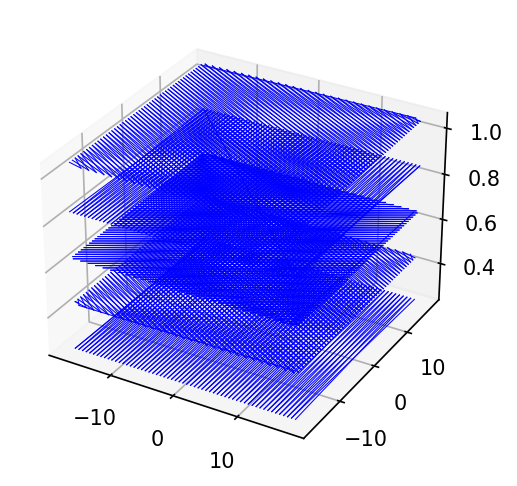

In [10]:
fig = plt.figure(dpi=150)
ax = plt.axes(projection='3d')

x_pos, y_pos, z_pos = history[0]['COORDS']

for j, h in enumerate(history[1:]):
    x_0, y_0, z_0 = history[j-1]['COORDS']
    x_0 = 0 if x_0 is None else x_0
    y_0 = 0 if y_0 is None else y_0
    z_0 = 0 if z_0 is None else z_0

    x_f, y_f, z_f = h['COORDS']
    x_f = 0 if x_f is None else x_f
    y_f = 0 if y_f is None else y_f
    z_f = 0 if z_f is None else z_f
    
    fmt = {
        'ls': '-' if h['PRINTING'] else '--',
        'c': 'b' if h['PRINTING'] else 'k',
        'lw': .5 if h['PRINTING'] else 0.1
    }
    if h['REL_MODE']:
        x_pts = np.round(np.array([x_0, x_f]) + x_pos, 6)
        y_pts = np.round(np.array([y_0, y_f]) + y_pos, 6)
        z_pts = np.round(np.array([z_0, z_f]) + z_pos, 6)

        x_pos, y_pos, z_pos = x_pos+x_f, y_pos+y_f, z_pos+z_f
    else:
        x_pts = [x_0, x_f]
        y_pts = [y_0, y_f]
        z_pts = [z_0, z_f]
    
    if h['PRINTING']:
        ax.plot3D(x_pts, y_pts, z_pts, **fmt)
plt.show()